# Identifying cancer subtypes using graph-based clustering

This is the main notebook for executing the code corresponding to the project report. First, we import all the necessary packages and load the functions from our external Python files.

In [4]:
import pandas as pd
import numpy as np
import os
import joblib
import matplotlib.pyplot as plt
import networkx as nx
from IPython.display import Image

In [8]:
from initial_analysis import *
from settings.general_settings import *
from settings.path_settings import *
from evaluation import *
from similarity_graph import get_similarity_graph
from clustering.HCS_algo import HCS_labels
from clustering.singletons_adaptation import adapt_singletons

We set the parameter for running the notebook. To set the parameters for the construction of the similarity graph, please use the 'general_settings.py' file. The paths for saving and loading partial results can be changed in the 'path_settings.py' file. Both files are located in the 'settings' folder.

In [11]:
use_saved_results = True

## Loading the data set
First, we use the 'load_data()' function imported from and further explained in the 'initial_analysis.py' file and then display an overview of the data set. Next, we use the 'get_data_overiew()' function also imported and further explained in the 'initial_analysis.py' file to perform an initial analysis of the data.

In [14]:
# load the data set
df_rna = load_data(add_labels=False)
print(df_rna.shape)
df_joined = load_data(add_labels=True)

# get an overview of the data set
display(df_rna.head())

# perform an initial analysis of the data set
df_summary = get_data_overview(df_joined=df_joined)
display(df_summary)

,gene_0,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,gene_9,...,gene_20521,gene_20522,gene_20523,gene_20524,gene_20525,gene_20526,gene_20527,gene_20528,gene_20529,gene_20530
sample_0,0.0,2.017209,3.265527,5.478487,10.431999,0.0,7.175175,0.591871,0.0,0.0,...,4.926711,8.210257,9.723516,7.220030,9.119813,12.003135,9.650743,8.921326,5.286759,0.0
sample_1,0.0,0.592732,1.588421,7.586157,9.623011,0.0,6.816049,0.000000,0.0,0.0,...,4.593372,7.323865,9.740931,6.256586,8.381612,12.674552,10.517059,9.397854,2.094168,0.0
sample_2,0.0,3.511759,4.327199,6.881787,9.870730,0.0,6.972130,0.452595,0.0,0.0,...,5.125213,8.127123,10.908640,5.401607,9.911597,9.045255,9.788359,10.090470,1.683023,0.0
sample_3,0.0,3.663618,4.507649,6.659068,10.196184,0.0,7.843375,0.434882,0.0,0.0,...,6.076566,8.792959,10.141520,8.942805,9.601208,11.392682,9.694814,9.684365,3.292001,0.0
sample_4,0.0,2.655741,2.821547,6.539454,9.738265,0.0,6.566967,0.360982,0.0,0.0,...,5.996032,8.891425,10.373790,7.181162,9.846910,11.922439,9.217749,9.461191,5.110372,0.0


,Percentage,description,only zero-valued attributes,attributes with at least one zero-valued sample,only non-zero-valued attributes
Class,,,,,
BRCA,0.374532,Breast invasive carcinoma,0.016999,0.347134,0.652915
COAD,0.097378,Colon adenocarcinoma,0.034095,0.307632,0.692416
KIRC,0.182272,Kidney renal clear cell carcinoma,0.017388,0.298768,0.701281
LUAD,0.176030,Lung adenocarcinoma,0.024012,0.307145,0.692903
PRAD,0.169788,Prostate adenocarcinoma,0.022649,0.321465,0.678584


For the algorithm, we now subset the data set according to the list 'classes' that we defined above. The particular choice of classes is discussed in the project report. The 'subset_data()' is imported and further explained in 'initial_analysis.py'.

In [19]:
df_subset = subset_data(df_joined, drop_label=True)
print(df_subset.shape)
display(df_subset.head())

,gene_0,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,gene_9,...,gene_20521,gene_20522,gene_20523,gene_20524,gene_20525,gene_20526,gene_20527,gene_20528,gene_20529,gene_20530
sample_0,0.0,2.017209,3.265527,5.478487,10.431999,0.0,7.175175,0.591871,0.0,0.0,...,4.926711,8.210257,9.723516,7.220030,9.119813,12.003135,9.650743,8.921326,5.286759,0.0
sample_1,0.0,0.592732,1.588421,7.586157,9.623011,0.0,6.816049,0.000000,0.0,0.0,...,4.593372,7.323865,9.740931,6.256586,8.381612,12.674552,10.517059,9.397854,2.094168,0.0
sample_2,0.0,3.511759,4.327199,6.881787,9.870730,0.0,6.972130,0.452595,0.0,0.0,...,5.125213,8.127123,10.908640,5.401607,9.911597,9.045255,9.788359,10.090470,1.683023,0.0
sample_3,0.0,3.663618,4.507649,6.659068,10.196184,0.0,7.843375,0.434882,0.0,0.0,...,6.076566,8.792959,10.141520,8.942805,9.601208,11.392682,9.694814,9.684365,3.292001,0.0
sample_5,0.0,3.467853,3.581918,6.620243,9.706829,0.0,7.758510,0.000000,0.0,0.0,...,5.726657,8.602588,9.928339,6.096154,9.816001,11.556995,9.244150,9.836473,5.355133,0.0


## Similarity graph
In this part, we construct the similarity graph corresponding to the data set under consideration. To this end, we import the 'get_similarity_graph()' function from the 'similarity_graph.py' file. In this file, all the parameters, functions for partial results and steps of the algorithm are explained in the comments.

In [24]:
if use_saved_results:
    G = joblib.load(os.path.join(path_data + ''.join(['G_sigma=', str(sigma), '_eps=', str(epsilon), '_weighted=', str(weighted), '.joblib'])))
else:
    G = get_similarity_graph(df=df_subset)

Next, we visualize the constructed similarity graph. Note that the already saved plots can look different from the direct networkx plot due to different orientations and specific settings to make the plot more readable in some cases.

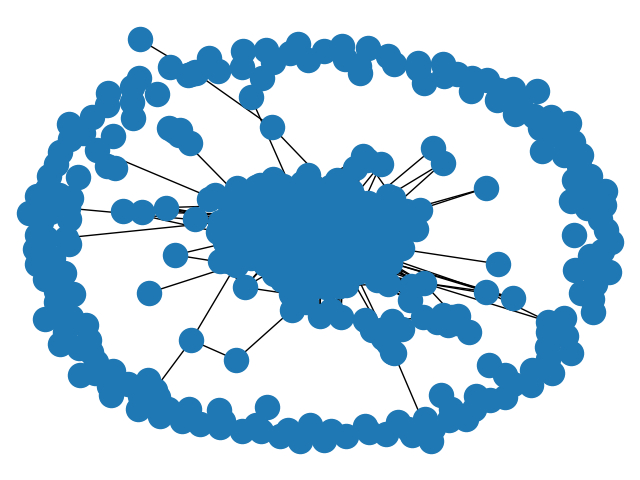

In [27]:
if use_saved_results:
    display(Image(path_data + ''.join(['G_sigma=', str(sigma), '_epsilon=', str(epsilon), '_weighted=', str(weighted), '.png'])))
else:
    nx.draw_networkx(G, with_labels=False)

## HCS clustering
In this part, we perform the HCS clustering and get the resulting clustering labels. For this we import the 'HCS_labels()' function from the 'HCS_algo.py' file in the 'clustering' folder. In this file, all the parameters, functions for partial results and steps of the algorithm are explained in the comments.

In [30]:
if use_saved_results:
    labels = joblib.load(os.path.join(path_data + ''.join(['labels_sigma=', str(sigma), '_eps=', str(epsilon), '_weighted=', str(weighted), '.joblib'])))
else:
    labels = HCS_labels(G=G)

Next, we reassign the observations in the singleton clusters using the procedure discussed in the project report. We import the 'adapt_singletons()' function from the 'singletons_adaptation.py' file in the 'clustering' folder. In this file, all the parameters, functions for partial results and steps of the algorithm are explained in the comments.

In [33]:
if use_saved_results:
    new_labels = joblib.load(os.path.join(path_data + ''.join(['new_labels_sigma=', str(sigma), '_eps=', str(epsilon), '_weighted=', str(weighted), '.joblib'])))
else:
    new_labels = adapt_singletons(df=df_subset, labels=labels)

## Evaluate and review the clustering results
In this section, we first view the sizes of the clusters using the new_labels calculated above. For this we import the 'get_cluster_sizes()' function from the 'evaluation.py' file. In this file, all the parameters, functions for partial results and steps of the algorithm are explained in the comments.

In [36]:
cluster_sizes = get_cluster_sizes(new_labels=new_labels)
display(cluster_sizes)

,class,size
0,2,136
1,148,121
2,68,118
3,140,27
4,153,21


Next, we collect the data necessary to reconstruct the bar chart that is visualized in the project report to view the distribution of the clustering labels among the true classes. To this end, we import the 'get_bar_chart_data()' function from the 'evaluation.py' file. In this file, all the parameters, functions for partial results and steps of the algorithm are explained in the comments.

In [39]:
class_sizes = get_bar_chart_data(df_joined=df_joined, new_labels=new_labels)
display(class_sizes)

,class,size,distr_labels
0,KIRC,146,"{148: 0.00684931506849315, 140: 0.184931506849..."
1,LUAD,141,"{153: 0.14893617021276595, 148: 0.851063829787..."
2,PRAD,136,{2: 1.0}
